In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta
from dateutil import parser

In [ ]:
def time_to_datetime(s, default_date=None):
    """
    Convert a time or datetime string into a datetime object.
    If the string contains a date, use that date.
    If the string only contains a time, use the provided default_date.
    If parsing fails, return None.
    
    Args:
        s (str | datetime | None): Input timestamp or time string
        default_date (datetime.date): Used when s has no date component

    Returns:
        datetime or None
    """
    
    # No value → return None
    if pd.isna(s):
        return None

    # Already datetime → return as-is (normalized)
    if isinstance(s, datetime):
        return s.replace(tzinfo=None)

    # Convert to string
    s = str(s).strip()

    # CASE 1 — Looks like a pure HH:MM time string
    if ":" in s and len(s.split(":")[0]) <= 2 and len(s.split(":")[1]) <= 2:
        hh, mm = map(int, s.split(":"))
        if default_date is None:
            return None  # cannot build a full datetime without a date
        return datetime.combine(default_date, time(hh, mm))

    # CASE 2 — Let the parser decide (handles full datetime strings)
    try:
        dt = parser.parse(s)
        dt = dt.astimezone(tz=None).replace(tzinfo=None) if dt.tzinfo else dt
        return dt
    except Exception:
        return None

C:\Users\niels\AppData\Local\Temp\ipykernel_16820\2182791645.py:28: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  pd.to_datetime(df_other_train['Stop:Arrival time']) +
C:\Users\niels\AppData\Local\Temp\ipykernel_16820\2182791645.py:28: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  pd.to_datetime(df_other_train['Stop:Arrival time']) +
C:\Users\niels\AppData\Local\Temp\ipykernel_16820\2182791645.py:35: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, plea

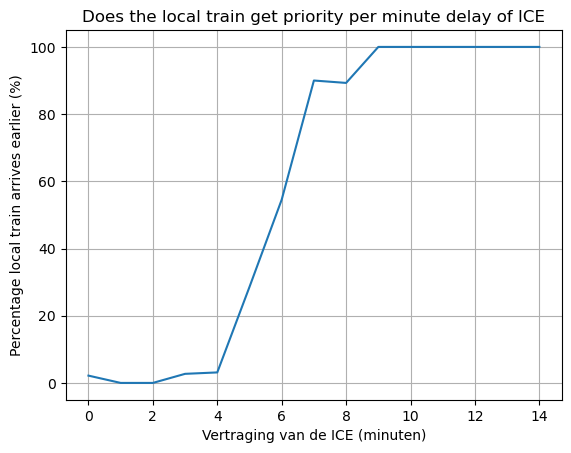

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Services/all_interesting_services.csv")

ICE_value = 242
collision_train = 31228

results = {}

for i in range(15):

    late_rows = df[
        (df['Stop:Station name'] == 'Bad Bentheim') &
        (df['Stop:Departure delay'] == i) &
        (df['Service:Train number'] == ICE_value)
    ]

    dagen = late_rows['Service:Date'].unique()
    subset = df[df['Service:Date'].isin(dagen)]

    # Remove partially cancelled trains
    subset_2 = subset[subset['Service:Partly cancelled'] != True]

    # 203xx subset
    df_other_train = subset_2[(subset_2['Service:Train number'] == collision_train) & (subset_2['Stop:Station name'] == "Hengelo")].copy()
    df_other_train['actual_arrival'] = (
        pd.to_datetime(df_other_train['Stop:Arrival time']) +
        pd.to_timedelta(df_other_train['Stop:Arrival delay'], unit='m')
    )
    
    # ICE subset
    df_ice = subset_2[(subset_2['Service:Train number'] == ICE_value) & (subset_2['Stop:Station name'] == "Hengelo")].copy()
    df_ice['actual_arrival'] = (
        pd.to_datetime(df_ice['Stop:Arrival time']) +
        pd.to_timedelta(df_ice['Stop:Arrival delay'], unit='m')
    )

    # Merge on date
    merged = pd.merge(
        df_other_train[['Service:Date', 'actual_arrival']],
        df_ice[['Service:Date', 'actual_arrival']],
        on='Service:Date',
        how='inner',
        suffixes=('_203', '_ice')
    )

    # Compare
    if len(merged) > 0:
        merged['203_earlier'] = merged['actual_arrival_203'] < merged['actual_arrival_ice']
        merged[i] = i
        percentage_earlier = merged['203_earlier'].mean() * 100
        results[i] = percentage_earlier
    else:
        results[i] = None
        

# To DataFrame
df_results = pd.DataFrame({
    "delay_minutes": list(results.keys()),
    "percentage_earlier": list(results.values())
})

# Plot
plt.plot(df_results["delay_minutes"], df_results["percentage_earlier"])
plt.xlabel("ICE delay (minutes)")
plt.ylabel("Percentage local train arrives earlier (%)")
plt.title("Does the local train get priority per minute delay of ICE")
plt.grid(True)
plt.show()


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def compute_priority_effect(df, ice_train, local_train,
                            delay_station="Bad Bentheim",
                            compare_station="Hengelo",
                            max_delay=15):
    
    results = {}

    for i in range(max_delay):
        late_rows = df[
            (df['Stop:Station name'] == delay_station) &
            (df['Stop:Departure delay'] == i) &
            (df['Service:Train number'] == ice_train)
        ]

        dagen = late_rows['Service:Date'].unique()
        subset = df[df['Service:Date'].isin(dagen)]

        # Remove partially cancelled trains
        subset_2 = subset[subset['Service:Partly cancelled'] != True]

        # Local train subset
        df_local = subset_2[
            (subset_2['Service:Train number'] == local_train) &
            (subset_2['Stop:Station name'] == compare_station)
        ].copy()

        df_local['actual_arrival'] = (
            pd.to_datetime(df_local['Stop:Arrival time']) +
            pd.to_timedelta(df_local['Stop:Arrival delay'], unit='m')
        )

        # ICE subset
        df_ice = subset_2[
            (subset_2['Service:Train number'] == ice_train) &
            (subset_2['Stop:Station name'] == compare_station)
        ].copy()

        df_ice['actual_arrival'] = (
            pd.to_datetime(df_ice['Stop:Arrival time']) +
            pd.to_timedelta(df_ice['Stop:Arrival delay'], unit='m')
        )

        # Merge
        merged = pd.merge(
            df_local[['Service:Date', 'actual_arrival']],
            df_ice[['Service:Date', 'actual_arrival']],
            on='Service:Date',
            suffixes=('_local', '_ice')
        )

        if len(merged) > 0:
            merged['local_earlier'] = merged['actual_arrival_local'] < merged['actual_arrival_ice']
            results[i] = merged['local_earlier'].mean() * 100
        else:
            results[i] = None

    return pd.DataFrame({
        "delay_minutes": list(results.keys()),
        "percentage_earlier": list(results.values())
    })


C:\Users\niels\AppData\Local\Temp\ipykernel_16820\4211226654.py:31: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  pd.to_datetime(df_local['Stop:Arrival time']) +
C:\Users\niels\AppData\Local\Temp\ipykernel_16820\4211226654.py:31: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  pd.to_datetime(df_local['Stop:Arrival time']) +
C:\Users\niels\AppData\Local\Temp\ipykernel_16820\4211226654.py:42: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `appl

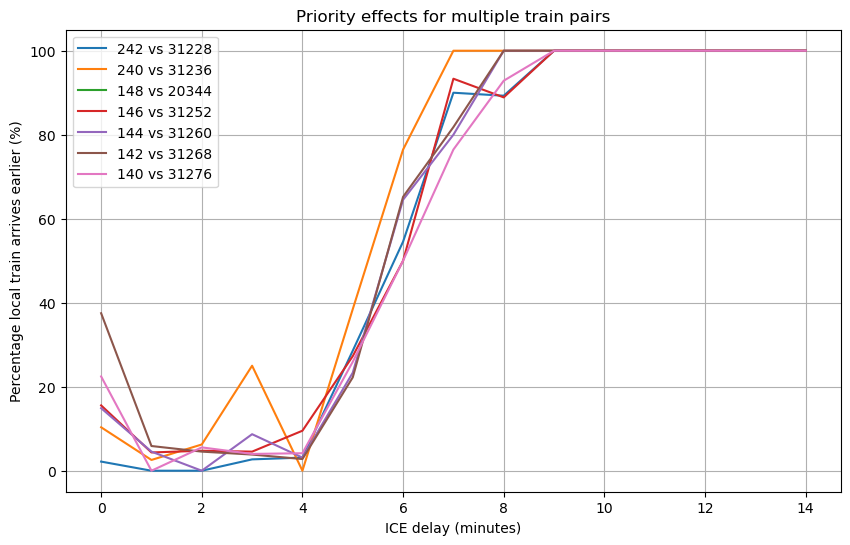

In [4]:
train_pairs = [
    (242, 31228),   # ICE -> 203xx
    (240, 31236),   # ICE -> andere regionale trein
    (148, 20344),   # ander ICE -> regionale trein
    (146, 31252),
    (144, 31260),
    (142, 31268),
    (140, 31276),
]

plt.figure(figsize=(10, 6))

for ice, local in train_pairs:
    df_res = compute_priority_effect(df, ice, local)
    plt.plot(df_res["delay_minutes"], df_res["percentage_earlier"],
             label=f"{ice} vs {local}")

plt.xlabel("ICE delay (minutes)")
plt.ylabel("Percentage local train arrives earlier (%)")
plt.title("Priority effects for multiple train pairs")
plt.grid(True)
plt.legend()
plt.show()